# Audubon Christmas Bird Count - Issue 36

## Prep for Analysis: Getting to know the CBC and NOAA Data

Updated: February 17, 2020<br>
Minor changes:<br>
By: Ian Davis<br>

Inputs: ../data/cbc_cleaned_usa_merged.csv<br>
Outputs: none yet; just plots & calcs printed to the notebook<br>

### See data dictionary: 

http://www.audubon.org/sites/default/files/documents/cbc_report_field_definitions_2013.pdf

In [1]:
import numpy as np
import pandas as pd
import plotly_express as px
import matplotlib.pyplot as plt
import datetime
from scipy import stats

pd.set_option('display.max_columns', 500)

In [2]:
# Read in unfinished dataset
df_paired = pd.read_csv('../data/cbc_cleaned_usa_merged.csv')

# Set the index
df_paired.set_index('Unnamed: 0')

c:\users\ijd50\appdata\local\programs\python\python37-32\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning:

Columns (28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.



,circle_name,country_state,lat,lon,count_year,count_date,n_field_counters,n_feeder_counters,min_field_parties,max_field_parties,field_hours,feeder_hours,nocturnal_hours,field_distance,nocturnal_distance,distance_units,min_temp,max_temp,temp_unit,min_wind,max_wind,wind_unit,min_snow,max_snow,snow_unit,am_cloud,pm_cloud,am_rain,pm_rain,am_snow,pm_snow,field_distance_imperial,field_distance_metric,nocturnal_distance_imperial,nocturnal_distance_metric,min_snow_imperial,min_snow_metric,max_snow_metric,max_snow_imperial,min_temp_imperial,max_temp_imperial,min_temp_metric,max_temp_metric,min_wind_metric,max_wind_metric,min_wind_imperial,max_wind_imperial,station_key,circle_coordinates,closest_station_id,closest_station_lat,closest_station_lng,distance,circle_num,date,id,name,precipitation_value,state,temp_max_value,temp_min_value
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,Pacific Grove,US-CA,36.616700,-121.916700,1901,1900-12-25,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(36.61670, -121.9167)","(36.61670, -121.9167)",USC00047916,36.9878,-121.9994,41928.062371,2,1900-12-25,USC00047916,SANTA CRUZ,0.0,CA,172.0,33.0
1,Pueblo,US-CO,38.175251,-104.519575,1901,1900-12-25,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(38.175251, -104.519575)","(38.175251, -104.519575)",USW00023068,38.2725,-104.6089,13338.679404,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bristol,US-CT,41.671800,-72.949500,1901,1900-12-25,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(41.67180, -72.94950)","(41.67180, -72.94950)",USC00061536,41.8000,-72.9333,14322.471705,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Norwalk,US-CT,41.116700,-73.400000,1901,1900-12-25,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(41.11670, -73.40000)","(41.11670, -73.40000)",USC00065892,41.1333,-73.4500,4578.046523,5,1900-12-25,USC00065892,NORWALK,0.0,CT,67.0,-44.0
4,Glen Ellyn,US-IL,41.883300,-88.066700,1901,1900-12-25,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(41.88330, -88.06670)","(41.88330, -88.06670)",USC00119221,41.8128,-88.0728,7857.728111,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89563,Hayward,US-WI,46.010021,-91.290002,2016,2015-12-19,5.0,7.0,4.0,4.0,5.00,17.50,NaN,90.75,NaN,Miles,6.0,21.0,2.0,5.80,10.4,1.0,5.9,5.90,2.0,2.0,5.0,3,3,2,2,90.75,146.041197,NaN,NaN,5.9,14.986,14.9860,5.90,6.0,21.0,-14.444444,-6.111111,9.333762,16.736402,5.80,10.4,"(46.010021, -91.290002)","(46.010021, -91.290002)",USW00094973,46.0261,-91.4442,12043.634721,101706,2015-12-19,USW00094973,HAYWARD MUNI AP,0.0,WI,-60.0,-143.0
89564,Copper Center,US-AK,62.019112,-145.369224,2013,2012-12-14,7.0,4.0,7.0,8.0,3.58,8.75,0.01,16.55,0.01,Miles,-4.0,21.9,2.0,2.53,5.1,1.0,9.8,9.80,2.0,6.0,6.0,3,3,3,3,16.55,26.633408,0.01,0.016093,9.8,24.892,24.8920,9.80,-4.0,21.9,-20.000000,-5.611111,4.071452,8.207274,2.53,5.1,"(62.019112, -145.369224)","(62.019112, -145.369224)",USC00503304,62.1086,-145.5331,13114.478871,92546,2012-12-14,USC00503304,GLENNALLEN KCAM,0.0,AK,-133.0,-211.0
89565,Washington Island,US-WI,45.383338,-86.883312,2017,2016-12-17,4.0,20.0,2.0,2.0,12.75,20.00,NaN,87.50,NaN,Miles,12.0,23.0,2.0,11.00,34.0,1.0,9.8,9.80,2.0,2.0,2.0,3,3,3,3,87.50,140.811072,NaN,NaN,9.8,24.892,24.8920,

### Calculated Variables:<br>

Convert NOAA temp's from 10th of a degree to degrees:

In [3]:
df_paired.loc[:, 'noaa_tmax_value'] = df_paired.loc[:, 'temp_max_value'] / 10.0 * 1.8 + 32.0
df_paired.loc[:, 'noaa_tmin_value'] = df_paired.loc[:, 'temp_min_value'] / 10.0 * 1.8 + 32.0

Are there indeces which have negative values for both CBC and NOAA?

In [4]:
df_paired.loc[((df_paired.loc[:, 'min_temp'] < 0.0) & 
               (df_paired.loc[:, 'noaa_tmin_value'] < 0.0))].index.size

1665

Any negative temperatures in Florida?<br>
Lat: 25 to 30<br>
Long: -80 to -90

In [5]:
df_paired.loc[((df_paired.loc[:, 'noaa_tmin_value'] < 0.0) &
               (df_paired.loc[:, 'closest_station_lat'] < 30.0) &
               (df_paired.loc[:, 'closest_station_lng'] > -90.0))].index.size

0

In [6]:
df_paired.loc[((df_paired.loc[:, 'noaa_tmin_value'] < 0.0) &
               (df_paired.loc[:, 'closest_station_lat'] < 30.0) &
               (df_paired.loc[:, 'closest_station_lng'] > -90.0)),
               ['noaa_tmin_value', 'circle_name', 'count_date', 'closest_station_lat', 'closest_station_lng']].tail(10)

,noaa_tmin_value,circle_name,count_date,closest_station_lat,closest_station_lng


Create variable(s) to track if CBC recorded precipitation:<br>
- cbc_is_prec
- cbc_is_snow
- cbc_is_rain

- Are there any 'min_snow' values larger than 'max_snow' ?

In [7]:
df_paired.loc[(df_paired.loc[:, 'min_snow'] > df_paired.loc[:, 'max_snow'])].index.size

5

In [8]:
df_paired.loc[(df_paired.loc[:, 'min_snow'] > df_paired.loc[:, 'max_snow']), ['circle_name', 'count_date', 'min_snow', 'max_snow']]

,circle_name,count_date,min_snow,max_snow
62929,Southern Dorchester County,1962-12-26,3.0,0.0
67182,Waukesha,2011-12-17,5.0,1.0
67645,Presque Isle,2011-12-31,2.0,1.0
67840,Caribou,2011-12-28,4.0,1.0
74684,Angel Fire-Eagle Nest,2011-12-18,12.0,3.0


In [9]:
# Sometime the rain or snow intensity is listed as "2,1"
df_paired.loc[:, 'am_rain'].value_counts()

3        33615
4        23810
2         7087
1          940
2,1        422
3,2        356
3,2,1      126
3,1         19
4.0         11
2,3          3
3,4          2
1,2          2
1,4          1
1,2,3        1
2.0          1
Name: am_rain, dtype: int64

In [10]:
df_paired.loc[:, 'cbc_is_prec'] = (pd.notna(df_paired.loc[:, 'min_snow']) |
                                  pd.notna(df_paired.loc[:, 'max_snow']) |
                                  pd.notna(df_paired.loc[:, 'am_rain']) |
                                  pd.notna(df_paired.loc[:, 'pm_rain']))
df_paired.loc[(df_paired.loc[:, 'cbc_is_prec'] == True)].index.size

66877

In [11]:
# Check for false positives
df_paired.loc[(df_paired.loc[:, 'cbc_is_prec'] == True) &
              (pd.isna(df_paired.loc[:, 'min_snow']) &
               pd.isna(df_paired.loc[:, 'max_snow']) &
               pd.isna(df_paired.loc[:, 'am_rain']) &
               pd.isna(df_paired.loc[:, 'pm_rain'])),
              ['cbc_is_prec', 'min_snow', 'max_snow', 'am_rain', 'pm_rain']].head(10)

,cbc_is_prec,min_snow,max_snow,am_rain,pm_rain


Absolute Temperature Difference:

In [12]:
df_paired.loc[:, 'tmin_diff'] = df_paired.loc[:, 'min_temp'] - df_paired.loc[:, 'noaa_tmin_value']
df_paired.loc[:, 'tmin_diff_abs'] = df_paired.loc[:, 'tmin_diff'].abs()  

df_paired.loc[:, 'tmax_diff'] = df_paired.loc[:, 'max_temp'] - df_paired.loc[:, 'noaa_tmax_value']
df_paired.loc[:, 'tmax_diff_abs'] = df_paired.loc[:, 'tmax_diff'].abs() 

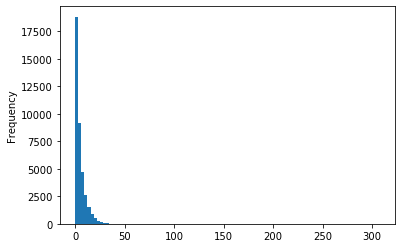

In [13]:
df_paired.loc[:, 'tmin_diff_abs'].plot.hist(bins=100)

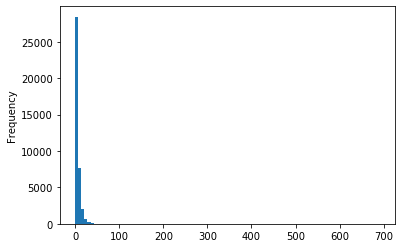

In [14]:
df_paired.loc[:, 'tmax_diff_abs'].plot.hist(bins=100)

Mean temperature difference:

In [15]:
tmin_diff_mean = df_paired.loc[:, 'tmin_diff_abs'].mean(skipna=True)
tmin_diff_std = df_paired.loc[:, 'tmin_diff_abs'].std(skipna=True)
tmax_diff_mean = df_paired.loc[:, 'tmax_diff_abs'].mean(skipna=True)
tmax_diff_std = df_paired.loc[:, 'tmax_diff_abs'].std(skipna=True)

print('Tmin Difference Mean & SD:', round(tmin_diff_mean,2), ', ', round(tmin_diff_std,2))
print('Tmax Difference Mean & SD:', round(tmax_diff_mean,2), ', ', round(tmax_diff_std,2))

Tmin Difference Mean & SD: 5.18 ,  5.65
Tmax Difference Mean & SD: 5.1 ,  7.6


### Outliers



Screen stations further than 10 km:

In [16]:
df_paired_10k = df_paired.loc[(df_paired.loc[:, 'distance'] <= 10000.0), :]
print('Rows in original dataset:', df_paired.index.size)
print('Rows in 10km dataset:', df_paired_10k.index.size)

Rows in original dataset: 89568
Rows in 10km dataset: 63975


Screen stations with obvious temperature errors:<br>
- tmin no less than -100 degF
- tmax no greater than 110 degF
- (probably could be more strict, but this is first guess)

In [17]:
df_paired_10k = df_paired_10k.loc[(df_paired_10k.loc[:, 'min_temp'] > -100.0) &
                                  (df_paired_10k.loc[:, 'noaa_tmin_value'] > -100.0) &
                                  (df_paired_10k.loc[:, 'max_temp'] < 110.0) &
                                  (df_paired_10k.loc[:, 'noaa_tmax_value'] < 110.0), :]
print('Rows in 10km temp-screened dataset:', df_paired_10k.index.size)

Rows in 10km temp-screened dataset: 27320


### ** THAT'S A BIG DROP OFF **

Mean temperature difference:

In [18]:
tmin_diff_mean = df_paired_10k.loc[:, 'tmin_diff_abs'].mean(skipna=True)
tmin_diff_std = df_paired_10k.loc[:, 'tmin_diff_abs'].std(skipna=True)
tmax_diff_mean = df_paired_10k.loc[:, 'tmax_diff_abs'].mean(skipna=True)
tmax_diff_std = df_paired_10k.loc[:, 'tmax_diff_abs'].std(skipna=True)

print('Tmin Difference Mean & SD:', round(tmin_diff_mean,2), ', ', round(tmin_diff_std,2))
print('Tmax Difference Mean & SD:', round(tmax_diff_mean,2), ', ', round(tmax_diff_std,2))

Tmin Difference Mean & SD: 5.08 ,  5.41
Tmax Difference Mean & SD: 4.94 ,  5.63


Box & Whisker Plots:<br>

Tmin & Tmax Difference

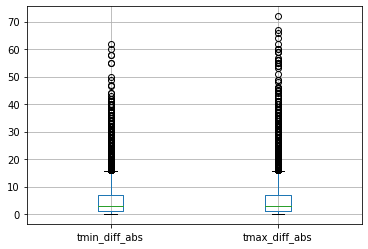

In [19]:
df_paired_10k.boxplot(column=['tmin_diff_abs', 'tmax_diff_abs'])

Clearly, there are some actual errors here. Not just outliers.

In [20]:
df_paired_10k.loc[(df_paired_10k.loc[:, 'tmin_diff_abs'].nlargest(20)).index,
              ['circle_name', 'count_date', 'distance', 'min_temp', 'noaa_tmin_value', 'tmin_diff_abs']]

,circle_name,count_date,distance,min_temp,noaa_tmin_value,tmin_diff_abs
35553,St. Augustine,1991-12-14,5928.604728,0.0,62.06,62.06
52695,Bradenton,1964-12-22,6581.551459,0.0,60.08,60.08
45689,Holcombe,2006-12-15,8048.504030,86.0,28.04,57.96
59258,Big Bear Lake,1965-01-02,4733.490448,50.0,-7.96,57.96
29524,North Pinellas,2005-12-18,9569.420529,0.0,55.04,55.04
76960,Binghamton,1970-01-01,5344.428941,-50.0,5.00,55.00
44347,Texarkana,1998-01-03,5437.838881,0.0,50.00,50.00
62959,Chattanooga,1966-01-02,7463.089148,5.0,53.96,48.96
87206,Tok,2001-12-19,852.431750,-31.0,15.98,46.98
65360,Big Rock,2016-12-18,4621.111552,30.0,-16.78,46.78


Calculate z-scores:

In [21]:
#df_paired.loc[:, 'cbc_tmin_z'] = stats.zscore(df_paired.loc[:, 'min_temp'], nan_policy='omit')
#df_paired.loc[:, 'cbc_tmax_z'] = stats.zscore(df_paired.loc[:, 'max_temp'])
#df_paired.loc[:, 'noaa_tmin_z'] = stats.zscore(df_paired.loc[:, 'noaa_tmin_value'])
#df_paired.loc[:, 'noaa_tmax_z'] = stats.zscore(df_paired.loc[:, 'noaa_tmax_value'])
df_paired_10k.loc[:, 'tmin_diff_z'] = stats.zscore(df_paired_10k.loc[:, 'tmin_diff_abs'], nan_policy='omit')
df_paired_10k.loc[:, 'tmax_diff_z'] = stats.zscore(df_paired_10k.loc[:, 'tmax_diff_abs'], nan_policy='omit')

In [22]:
df_paired_10k.loc[:, 'tmin_diff_z'].head(10)

8328     0.531923
9052     1.271614
10808    3.117142
11308   -0.585010
12288   -0.769933
18088   -0.030242
20141    0.724242
22431    0.180570
22533    1.645157
22538    0.369191
Name: tmin_diff_z, dtype: float64

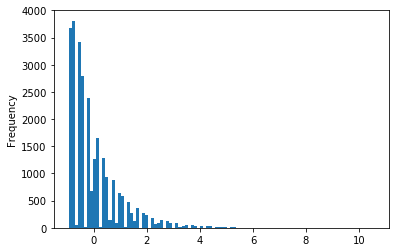

In [23]:
df_paired_10k.loc[:, 'tmin_diff_z'].plot.hist(bins=100)

Eliminate outliers (z > 2.96):

In [24]:
df_paired_noout = df_paired_10k.loc[((df_paired_10k.loc[:, 'tmin_diff_z'].abs() < 2.96) &
                                     (df_paired_10k.loc[:, 'tmax_diff_z'].abs() < 2.96))]

print('Rows in 10km temp-screened dataset:', df_paired_10k.index.size)
print('Rows in no outlier dataset:', df_paired_noout.index.size)

Rows in 10km temp-screened dataset: 27320
Rows in no outlier dataset: 26404


Show box & whisker plots again:

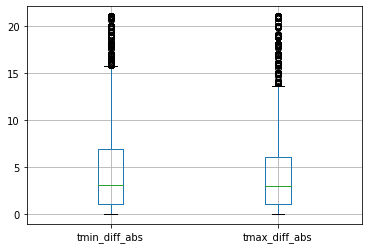

In [25]:
df_paired_noout.boxplot(column=['tmin_diff_abs', 'tmax_diff_abs'])

### Counting:<br>

Unique station count:

In [26]:
df_paired.loc[:, 'closest_station_id'].value_counts()
station_list = df_paired.loc[:, 'closest_station_id'].unique()
len(station_list)

7089

Total rows:

In [27]:
df_paired.index.size

89568

Rows with closest stations under 10 km:

In [28]:
df_paired_10k.index.size

27320

Histogram of station distances:

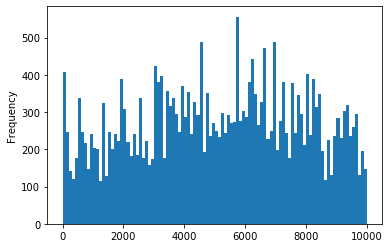

In [29]:
df_paired_10k.loc[:, 'distance'].plot.hist(bins=100)

Scatter plot of station distance with mean temperature difference:

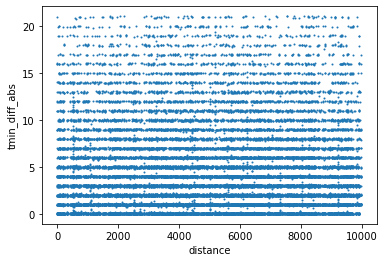

In [30]:
df_paired_noout.plot.scatter(x='distance',
                             y='tmin_diff_abs',
                             s=1)

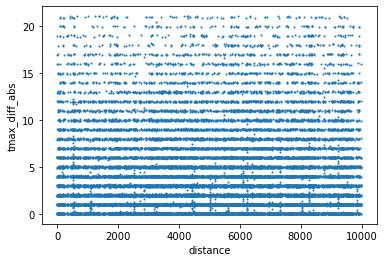

In [31]:
df_paired_noout.plot.scatter(x='distance',
                             y='tmax_diff_abs',
                             s=1)